# CHRONIC KIDNEY DISEASE PREDICTION USING DECISION TREE 

# IMPORTING LIBRARIES

In [2]:
#import SparkSeccion pyspark.sql
from pyspark.sql import SparkSession,Row
from pyspark.sql.functions import count,corr,col,sum

#import other libraries
import pandas as pd
import numpy as np

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.classification import DecisionTreeClassifier



In [3]:
#Create spark session
spark = SparkSession.builder.appName('decisiontree').getOrCreate()

In [4]:
#read the dataset and don't have specific header row

dataset = spark.read.option("header", "false").csv("kidney_disease.csv")

# Collect the first row to use as the header
header = dataset.first()

# Filter out the first row from the data
dataset = dataset.filter(dataset[0] != header[0])

# Here the dataset is converted to dataframe making the specific column as header since the datset
# is having columns names as a row
dataset = dataset.toDF(*header)

# Show the DataFrame
dataset.show(5)

+---+----+----+-----+---+---+------+--------+----------+----------+-----+----+---+-----+----+----+---+----+----+---+---+---+-----+---+---+--------------+
| id| age|  bp|   sg| al| su|   rbc|      pc|       pcc|        ba|  bgr|  bu| sc|  sod| pot|hemo|pcv|  wc|  rc|htn| dm|cad|appet| pe|ane|classification|
+---+----+----+-----+---+---+------+--------+----------+----------+-----+----+---+-----+----+----+---+----+----+---+---+---+-----+---+---+--------------+
|  0|48.0|80.0| 1.02|1.0|0.0|  NULL|  normal|notpresent|notpresent|121.0|36.0|1.2| NULL|NULL|15.4| 44|7800| 5.2|yes|yes| no| good| no| no|           ckd|
|  1| 7.0|50.0| 1.02|4.0|0.0|  NULL|  normal|notpresent|notpresent| NULL|18.0|0.8| NULL|NULL|11.3| 38|6000|NULL| no| no| no| good| no| no|           ckd|
|  2|62.0|80.0| 1.01|2.0|3.0|normal|  normal|notpresent|notpresent|423.0|53.0|1.8| NULL|NULL| 9.6| 31|7500|NULL| no|yes| no| poor| no|yes|           ckd|
|  3|48.0|70.0|1.005|4.0|0.0|normal|abnormal|   present|notpresent|117.0|56.

In [5]:
type(dataset)

pyspark.sql.dataframe.DataFrame

# EXPLORATORY DATA ANALYSIS

In [6]:
#printing the dataframe describtion
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- age: string (nullable = true)
 |-- bp: string (nullable = true)
 |-- sg: string (nullable = true)
 |-- al: string (nullable = true)
 |-- su: string (nullable = true)
 |-- rbc: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- pcc: string (nullable = true)
 |-- ba: string (nullable = true)
 |-- bgr: string (nullable = true)
 |-- bu: string (nullable = true)
 |-- sc: string (nullable = true)
 |-- sod: string (nullable = true)
 |-- pot: string (nullable = true)
 |-- hemo: string (nullable = true)
 |-- pcv: string (nullable = true)
 |-- wc: string (nullable = true)
 |-- rc: string (nullable = true)
 |-- htn: string (nullable = true)
 |-- dm: string (nullable = true)
 |-- cad: string (nullable = true)
 |-- appet: string (nullable = true)
 |-- pe: string (nullable = true)
 |-- ane: string (nullable = true)
 |-- classification: string (nullable = true)



In [7]:
#renaming the Columns to Exact terms
dataset = dataset.withColumnRenamed("age", "Age") \
       .withColumnRenamed("bp", "BloodPressure") \
       .withColumnRenamed("sg", "SpecificGravity") \
       .withColumnRenamed("al", "Albumin") \
       .withColumnRenamed("su", "Sugar") \
       .withColumnRenamed("rbc", "RedBloodCells") \
       .withColumnRenamed("pc", "PusCell") \
       .withColumnRenamed("pcc", "PusCellClumps") \
       .withColumnRenamed("ba", "Bacteria") \
       .withColumnRenamed("bgr", "BloodGlucoseRandom") \
       .withColumnRenamed("bu", "BloodUrea") \
       .withColumnRenamed("sc", "SerumCreatinine") \
       .withColumnRenamed("sod", "Sodium") \
       .withColumnRenamed("pot", "Potassium") \
       .withColumnRenamed("hemo", "Hemoglobin") \
       .withColumnRenamed("pcv", "PackedCellVolume") \
       .withColumnRenamed("wc", "WhiteBloodCellCount") \
       .withColumnRenamed("rc", "RedBloodCellCount") \
       .withColumnRenamed("htn", "Hypertension") \
       .withColumnRenamed("dm", "DiabetesMellitus") \
       .withColumnRenamed("cad", "CoronaryArteryDisease") \
       .withColumnRenamed("appet", "Appetite") \
       .withColumnRenamed("pe", "PedalEdema") \
       .withColumnRenamed("ane", "Anemia") \
       .withColumnRenamed("classification", "Classification")

# Show the DataFrame
dataset.show(5)

+---+----+-------------+---------------+-------+-----+-------------+--------+-------------+----------+------------------+---------+---------------+------+---------+----------+----------------+-------------------+-----------------+------------+----------------+---------------------+--------+----------+------+--------------+
| id| Age|BloodPressure|SpecificGravity|Albumin|Sugar|RedBloodCells| PusCell|PusCellClumps|  Bacteria|BloodGlucoseRandom|BloodUrea|SerumCreatinine|Sodium|Potassium|Hemoglobin|PackedCellVolume|WhiteBloodCellCount|RedBloodCellCount|Hypertension|DiabetesMellitus|CoronaryArteryDisease|Appetite|PedalEdema|Anemia|Classification|
+---+----+-------------+---------------+-------+-----+-------------+--------+-------------+----------+------------------+---------+---------------+------+---------+----------+----------------+-------------------+-----------------+------------+----------------+---------------------+--------+----------+------+--------------+
|  0|48.0|         80.0| 

In [8]:
#Printing total number of rows and columns in the dataset
print('Number of rows: \t', dataset.count())
print('Number of columns: \t', len(dataset.columns))

Number of rows: 	 400
Number of columns: 	 26


In [9]:
#How many people have kidney disease
dataset.groupBy('classification').count().show()

+--------------+-----+
|classification|count|
+--------------+-----+
|        notckd|  150|
|           ckd|  248|
|         ckd\t|    2|
+--------------+-----+



In [10]:
from pyspark.sql.functions import when

# Replace 'ckd\t' with 'ckd' and create a new DataFrame
dataset = dataset.withColumn(
    'Classification',
    when(dataset['Classification'] == 'ckd\t', 'ckd').otherwise(dataset['Classification'])
)

In [11]:
#How many people have kidney disease
dataset.groupBy('classification').count().show()

+--------------+-----+
|classification|count|
+--------------+-----+
|        notckd|  150|
|           ckd|  250|
+--------------+-----+



In [12]:
#checking the Number of NULL values for Each Column
for column in dataset.columns:
    count = dataset.filter(col(column).isNull()).count()
    print(f"'{column}': {count}")


'id': 0
'Age': 9
'BloodPressure': 12
'SpecificGravity': 47
'Albumin': 46
'Sugar': 49
'RedBloodCells': 152
'PusCell': 65
'PusCellClumps': 4
'Bacteria': 4
'BloodGlucoseRandom': 44
'BloodUrea': 19
'SerumCreatinine': 17
'Sodium': 87
'Potassium': 88
'Hemoglobin': 52
'PackedCellVolume': 70
'WhiteBloodCellCount': 105
'RedBloodCellCount': 130
'Hypertension': 2
'DiabetesMellitus': 2
'CoronaryArteryDisease': 2
'Appetite': 1
'PedalEdema': 1
'Anemia': 1
'Classification': 0


In [13]:
dataset.show()

+---+----+-------------+---------------+-------+-----+-------------+--------+-------------+----------+------------------+---------+---------------+------+---------+----------+----------------+-------------------+-----------------+------------+----------------+---------------------+--------+----------+------+--------------+
| id| Age|BloodPressure|SpecificGravity|Albumin|Sugar|RedBloodCells| PusCell|PusCellClumps|  Bacteria|BloodGlucoseRandom|BloodUrea|SerumCreatinine|Sodium|Potassium|Hemoglobin|PackedCellVolume|WhiteBloodCellCount|RedBloodCellCount|Hypertension|DiabetesMellitus|CoronaryArteryDisease|Appetite|PedalEdema|Anemia|Classification|
+---+----+-------------+---------------+-------+-----+-------------+--------+-------------+----------+------------------+---------+---------------+------+---------+----------+----------------+-------------------+-----------------+------------+----------------+---------------------+--------+----------+------+--------------+
|  0|48.0|         80.0| 

# FEATURE ENGINEERING

In [14]:
#converting the string columns with numerical values to float data type
from pyspark.sql.types import FloatType

cols = ['Albumin','BloodPressure','Sugar','Age',
        'SpecificGravity','BloodGlucoseRandom','BloodUrea','SerumCreatinine','Sodium','Potassium',
        'Hemoglobin','PackedCellVolume','WhiteBloodCellCount','RedBloodCellCount']
for col_name in cols:
    dataset = dataset.withColumn(col_name, col(col_name).cast(FloatType()))

In [15]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- Age: float (nullable = true)
 |-- BloodPressure: float (nullable = true)
 |-- SpecificGravity: float (nullable = true)
 |-- Albumin: float (nullable = true)
 |-- Sugar: float (nullable = true)
 |-- RedBloodCells: string (nullable = true)
 |-- PusCell: string (nullable = true)
 |-- PusCellClumps: string (nullable = true)
 |-- Bacteria: string (nullable = true)
 |-- BloodGlucoseRandom: float (nullable = true)
 |-- BloodUrea: float (nullable = true)
 |-- SerumCreatinine: float (nullable = true)
 |-- Sodium: float (nullable = true)
 |-- Potassium: float (nullable = true)
 |-- Hemoglobin: float (nullable = true)
 |-- PackedCellVolume: float (nullable = true)
 |-- WhiteBloodCellCount: float (nullable = true)
 |-- RedBloodCellCount: float (nullable = true)
 |-- Hypertension: string (nullable = true)
 |-- DiabetesMellitus: string (nullable = true)
 |-- CoronaryArteryDisease: string (nullable = true)
 |-- Appetite: string (nullable = true)
 |-- PedalE

In [16]:
#using the imputer feature in pyspark, the NULL values are replace by imputed value(BY DEFAULT ITS MEAN)
from pyspark.ml.feature import Imputer
cols_with_nulls = ['Albumin','BloodPressure','Sugar','Age','SpecificGravity',
                   'BloodGlucoseRandom','BloodUrea','SerumCreatinine','Sodium',
                   'Potassium','Hemoglobin','PackedCellVolume','WhiteBloodCellCount','RedBloodCellCount']
imputer = Imputer(inputCols=cols_with_nulls, outputCols=cols_with_nulls)
imputed_df = imputer.fit(dataset).transform(dataset)

In [17]:
imputed_df.show(5)

+---+----+-------------+---------------+-------+-----+-------------+--------+-------------+----------+------------------+---------+---------------+---------+---------+----------+----------------+-------------------+-----------------+------------+----------------+---------------------+--------+----------+------+--------------+
| id| Age|BloodPressure|SpecificGravity|Albumin|Sugar|RedBloodCells| PusCell|PusCellClumps|  Bacteria|BloodGlucoseRandom|BloodUrea|SerumCreatinine|   Sodium|Potassium|Hemoglobin|PackedCellVolume|WhiteBloodCellCount|RedBloodCellCount|Hypertension|DiabetesMellitus|CoronaryArteryDisease|Appetite|PedalEdema|Anemia|Classification|
+---+----+-------------+---------------+-------+-----+-------------+--------+-------------+----------+------------------+---------+---------------+---------+---------+----------+----------------+-------------------+-----------------+------------+----------------+---------------------+--------+----------+------+--------------+
|  0|48.0|      

In [18]:
#dropping rows with  NULL values [taken columns which had 1/2 NULL values]
imputed_df = imputed_df.dropna(subset=['Hypertension','DiabetesMellitus','CoronaryArteryDisease','Appetite','PedalEdema','Anemia','PusCellClumps','Bacteria'])

In [19]:
#removing columns with huge NULL values
imputed_df = imputed_df.drop('RedBloodCells','PusCell')


In [20]:
#Printing total number of rows and columns in the dataset
print('Number of rows: \t', imputed_df.count())


print('Number of columns: \t', len(imputed_df.columns))

Number of rows: 	 393
Number of columns: 	 24


In [21]:
#ENCODING OF CATEGORICAL COLUMNS

# Define a list of categorical columns
categorical_cols = ['PusCellClumps','Bacteria','Hypertension','DiabetesMellitus',
                    'CoronaryArteryDisease','Appetite','PedalEdema','Anemia','Classification']

# Create a list of StringIndexers for columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_encoded") for col in categorical_cols]

#  fits the StringIndexer to the data in the specified input column and then transform the data in the
#input column into encoded values. It will work in a loop.
for indexer in indexers:
    imputed_df = indexer.fit(imputed_df).transform(imputed_df)


In [22]:
imputed_df.show(4)

+---+----+-------------+---------------+-------+-----+-------------+----------+------------------+---------+---------------+---------+---------+----------+----------------+-------------------+-----------------+------------+----------------+---------------------+--------+----------+------+--------------+---------------------+----------------+--------------------+------------------------+-----------------------------+----------------+------------------+--------------+----------------------+
| id| Age|BloodPressure|SpecificGravity|Albumin|Sugar|PusCellClumps|  Bacteria|BloodGlucoseRandom|BloodUrea|SerumCreatinine|   Sodium|Potassium|Hemoglobin|PackedCellVolume|WhiteBloodCellCount|RedBloodCellCount|Hypertension|DiabetesMellitus|CoronaryArteryDisease|Appetite|PedalEdema|Anemia|Classification|PusCellClumps_encoded|Bacteria_encoded|Hypertension_encoded|DiabetesMellitus_encoded|CoronaryArteryDisease_encoded|Appetite_encoded|PedalEdema_encoded|Anemia_encoded|Classification_encoded|
+---+----+--

In [23]:
Kidney = imputed_df['Age', 'BloodPressure', 'SpecificGravity', 'Albumin', 'Sugar', 'BloodGlucoseRandom', 'BloodUrea',
       'SerumCreatinine', 'Sodium', 'Potassium', 'Hemoglobin',
       'PackedCellVolume', 'WhiteBloodCellCount', 'RedBloodCellCount','Hypertension_encoded', 'DiabetesMellitus_encoded',
       'CoronaryArteryDisease_encoded', 'Appetite_encoded',
       'PedalEdema_encoded', 'Anemia_encoded','Classification_encoded']
Kidney.show(3)

+----+-------------+---------------+-------+-----+------------------+---------+---------------+---------+---------+----------+----------------+-------------------+-----------------+--------------------+------------------------+-----------------------------+----------------+------------------+--------------+----------------------+
| Age|BloodPressure|SpecificGravity|Albumin|Sugar|BloodGlucoseRandom|BloodUrea|SerumCreatinine|   Sodium|Potassium|Hemoglobin|PackedCellVolume|WhiteBloodCellCount|RedBloodCellCount|Hypertension_encoded|DiabetesMellitus_encoded|CoronaryArteryDisease_encoded|Appetite_encoded|PedalEdema_encoded|Anemia_encoded|Classification_encoded|
+----+-------------+---------------+-------+-----+------------------+---------+---------------+---------+---------+----------+----------------+-------------------+-----------------+--------------------+------------------------+-----------------------------+----------------+------------------+--------------+----------------------+
|48.

# VISUALIZATION

In [24]:

#Using matplotlib and seaborm libraries of python for visualization

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
dataframe = imputed_df.toPandas()
dataframe.head()

,id,Age,BloodPressure,SpecificGravity,Albumin,Sugar,PusCellClumps,Bacteria,BloodGlucoseRandom,BloodUrea,...,Classification,PusCellClumps_encoded,Bacteria_encoded,Hypertension_encoded,DiabetesMellitus_encoded,CoronaryArteryDisease_encoded,Appetite_encoded,PedalEdema_encoded,Anemia_encoded,Classification_encoded
0,0,48.0,80.0,1.020,1.0,0.0,notpresent,notpresent,121.000000,36.0,...,ckd,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,7.0,50.0,1.020,4.0,0.0,notpresent,notpresent,148.036514,18.0,...,ckd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,62.0,80.0,1.010,2.0,3.0,notpresent,notpresent,423.000000,53.0,...,ckd,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,3,48.0,70.0,1.005,4.0,0.0,present,notpresent,117.000000,56.0,...,ckd,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,4,51.0,80.0,1.010,2.0,0.0,notpresent,notpresent,106.000000,26.0,...,ckd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


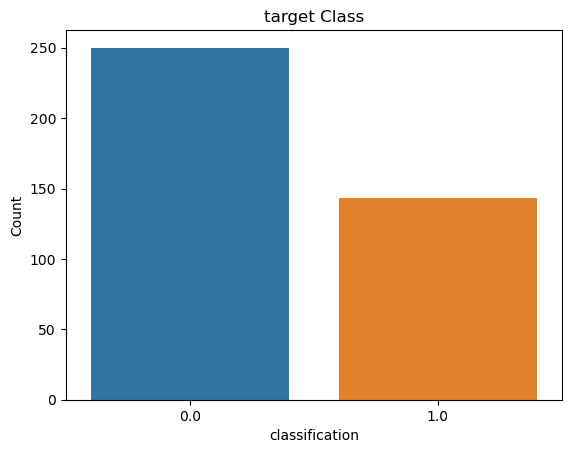

Percent of chronic kidney disease sample:  63.61 %
Percent of not a chronic kidney disease sample:  36.39 %


In [36]:
#showing the distribution of chronic and non chronic Kidney disease classification in the dataset and their percentage
sns.countplot(x='Classification_encoded',data=dataframe)
plt.xlabel("classification")
plt.ylabel("Count")
plt.title("target Class")
plt.show()
print('Percent of chronic kidney disease sample: ',round(len(dataframe[dataframe['Classification_encoded']==0])/len(dataframe['Classification_encoded'])*100,2),"%")
print('Percent of not a chronic kidney disease sample: ',round(len(dataframe[dataframe['Classification_encoded']==1])/len(dataframe['Classification_encoded'])*100,2),"%")

In [40]:
# Filter rows that have Chronic Kidney Disease
ckd_data = dataframe[dataframe['Classification'] == 'ckd']
ckd_data.Classification.value_counts()


Classification
ckd    250
Name: count, dtype: int64

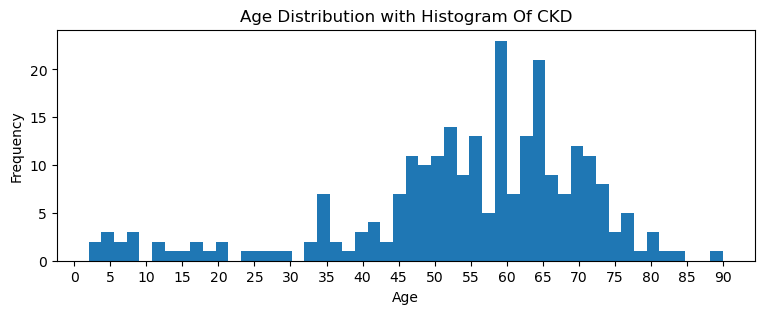

In [41]:
#Histogram of Age VS number of people with ckd 

def hist_plot(variable):
    plt.figure(figsize=(9,3))
    plt.hist(ckd_data[variable],bins=50)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90])
    plt.title("Age Distribution with Histogram Of CKD")
    plt.show()
numericVar = ["Age"]
for n in numericVar:
    hist_plot(n)

From the from the above graph we can see that the Chronic Kidney disease is highly affected to those who are betweenage of  45 and 70

In [37]:
# Define features and target columno
#Selecting features column from first to second last
features = Kidney.columns[:-1]

#Taking last column as output column
output = Kidney.columns[-1]

# Rename the output column to a valid name
output_renamed = "class"

# Assemble the feature columns into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol=output_renamed)
final_dataset = assembler.transform(Kidney)

In [38]:
final_dataset.show()

+----+-------------+---------------+---------+----------+------------------+---------+---------------+---------+---------+----------+----------------+-------------------+-----------------+--------------------+------------------------+-----------------------------+----------------+------------------+--------------+----------------------+--------------------+
| Age|BloodPressure|SpecificGravity|  Albumin|     Sugar|BloodGlucoseRandom|BloodUrea|SerumCreatinine|   Sodium|Potassium|Hemoglobin|PackedCellVolume|WhiteBloodCellCount|RedBloodCellCount|Hypertension_encoded|DiabetesMellitus_encoded|CoronaryArteryDisease_encoded|Appetite_encoded|PedalEdema_encoded|Anemia_encoded|Classification_encoded|               class|
+----+-------------+---------------+---------+----------+------------------+---------+---------------+---------+---------+----------+----------------+-------------------+-----------------+--------------------+------------------------+-----------------------------+----------------

# MODEL BUILDING

In [30]:
# Here we are splitting the data as 80% training and 20% testing set
train_data, test_data = final_dataset.randomSplit([0.8, 0.2], seed=42)

 ## Decision Tree Classifier

In [31]:
# Initialize DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(labelCol='Classification_encoded', featuresCol='class')

# MODEL FITTING

In [32]:
# Fit the classifier on the training data
dt_model = dt_classifier.fit(train_data)

# EVALUATE THE MODEL

In [33]:
# Make predictions on the test data
predictions = dt_model.transform(test_data)

# Evaluate the model
evaluator1 = MulticlassClassificationEvaluator(labelCol=output, predictionCol="prediction", metricName="accuracy")
accuracy_test = evaluator1.evaluate(predictions)

evaluator2 = MulticlassClassificationEvaluator(labelCol=output, predictionCol="prediction", metricName="f1")
f1score_test = evaluator2.evaluate(predictions)

print("Accuracy (Test Data):", accuracy_test)
print("F1 Score (Test Data):", f1score_test)

Accuracy (Test Data): 0.9473684210526315
F1 Score (Test Data): 0.9470870627956459


In [34]:
# Make predictions on the Train data
predictions = dt_model.transform(train_data)

# Evaluate the model
evaluator3 = MulticlassClassificationEvaluator(labelCol=output, predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator3.evaluate(predictions)


evaluator4 = MulticlassClassificationEvaluator(labelCol=output, predictionCol="prediction", metricName="f1")
f1score_train = evaluator4.evaluate(predictions)

print("Accuracy (Train Data):", accuracy_train)
print("F1 Score (Train Data):", f1score_train)

Accuracy (Train Data): 0.9970238095238095
F1 Score (Train Data): 0.9970211544285619


In [37]:
final_dataset.columns

['Age',
 'BloodPressure',
 'SpecificGravity',
 'Albumin',
 'Sugar',
 'BloodGlucoseRandom',
 'BloodUrea',
 'SerumCreatinine',
 'Sodium',
 'Potassium',
 'Hemoglobin',
 'PackedCellVolume',
 'WhiteBloodCellCount',
 'RedBloodCellCount',
 'Hypertension_encoded',
 'DiabetesMellitus_encoded',
 'CoronaryArteryDisease_encoded',
 'Appetite_encoded',
 'PedalEdema_encoded',
 'Anemia_encoded',
 'Classification_encoded',
 'class']

In [35]:
dt_model.featureImportances

SparseVector(20, {0: 0.0087, 2: 0.165, 5: 0.0228, 6: 0.0123, 10: 0.7339, 11: 0.0031, 13: 0.0161, 14: 0.0381})

dt_model.featureImportances: This attribute of the decision tree model dt_model contains information about the importance of each feature in the modedecision-making process.The indices correspond to the positions of the features in the dataset, and the values represent their respective importances. For example:

Feature 0 has an importance of 0.0087.
Feature 2 has an importance of 0.165.
Feature 5 has an importance of 0.0228.

SUMMARY

The project involves preprocessing clinical data related to kidney disease, performing feature engineering, encoding 
categorical variables, visualizing the data distribution, and preparing the dataset for modeling. It aims to predict 
chronic kidney disease based on various clinical parameters.Overall, the values in the project emphasize the importance of data preprocessing, feature engineering, visualization for insights, and proper preparation of the dataset to build accurate predictive models for chronic kidney disease and ended up with getting 94.7% accuracy in Test set and 99.7 % accuracy in Training set.